# Project 1: Assembling Genes

   <div class="alert alert-block alert-danger">
    <center>Due: <b>Monday, September 5, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    
For this assignment, you are encouraged to work with one other person satisfying the constraints from Class 2. 
You are permitted (actually _encouraged_) to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from previous semesters of this course, or from any other students in the class (other than your collaboration with your partner), and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>

Team Members (Names):  

Team Member UVA Computing IDs:

</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
    
External Resources Used:

</div>

In this project, we will explore genome assembly—the process of determining the order of nucleotides in DNA from fragmented reads. As you might have studied in the reading assignments, genome assembly can get quite complicated, as problems such as full sequence coverage, finding a good length for reads (the $k$ in $k$-mer), and sequencing errors present challenges for sequencing analysis and accuracy. You can assume perfect coverage for all parts of the assignment and no read errors for the first two questions.


<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: <a href="https://forms.gle/rNTXfYojTLEQ8idg6"><em>https://forms.gle/rNTXfYojTLEQ8idg6</em></a>. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name <i>uvaid1\_uvaid2.ipynb</i> (where <i>uvaidn</i> is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm (EST) on Monday, September 5.

## Install basic required packages.

- Install basic required packages, should be run only once. You may need to restart the kernel after this stage.
- Make sure you have [graphviz](https://graphviz.org/download/) installed on your system.
- The second cell adds Graphviz to your path, you may have to change based on where the install folder is.

<b>NOTE: We provide utils.py, which may contain helpful functions for you to use, as well as gvmagic.py, which is a deprecated package to use graphviz within the notebook</b>

In [1]:
%pip install -r requirements.txt

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

## Genome Assembly

For this part, you're given reads generated while trying to sequence the DNA of a TeleTubby (some unknown organism) with a \textit{very} small genetic code. By answering the following questions, you will learn how to assemble the original genome sequence from sequence reads.

Sequencing data is often stored in FASTQ file format. In TeleTubby.fastq, you will find the data organized in a particular order that repeats every four lines. The first line contains the metadata that encodes the name of the read, the experiment type, the kind of sequencing machine used, etc. The second line is the sequence of bases. The third line functions as a placeholder line. The fourth line is a sequence of base qualities that encode the qualities for the corresponding bases in the sequence line. We will only work with the sequence and quality score lines in this question.

In [5]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import utils
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

#### Question 1.1.1 GC-content

The GC-content (or the ratio of G and C nucleotides) is related to the melting temperature of the DNA double helix. Use the following equation to calculate the melting temperature of DNA for TeleTubby $t_m$ in Celsius:

\begin{equation*}
t_m = 64.9+0.41(\%GC)-\frac{500}{\text{length of sequence}}
\end{equation*}

As a reference, the human genome is known to have between 35%-60% GC-content. 

In [6]:
# Read sequence reads (error-free) from file
sequence_reads, qualities = utils.read_fastq('TeleTubby.fastq')
# print(sequence_reads)
sequence_len = len(sequence_reads) * 8

# Calculate %GC content
chars = []
for i in range(len(sequence_reads)):
    seq = sequence_reads[i]
    for j in seq:
        chars.append(j)
        
GC_percent = (chars.count('G') + chars.count('C')) / sequence_len
print("%GC content:", GC_percent * 100)

# Print out temperature in Celsius

temp_c = 64.9 + (0.41 * GC_percent) - (500 / sequence_len)
print("Temperature in celsius:", temp_c)

%GC content: 47.95221843003413
Temperature in celsius: 64.88329351535837


#### Question 1.1.2 Interpreting quality scores

Phred33 quality scores are represented as the character with an ASCII code equal to its value + 33 (to make them easy to print alongside genome sequences). List the top 5 most frequent scores in ASCII symbol as well as their Phredd33 scores in TeleTubby.fastq. You can refer to the [official Illumina website](https://support.illumina.com/help/BaseSpace_OLH_009008/Content/Source/Informatics/BS/QualityScoreEncoding_swBS.htm) to reference the scoring encoding.

What is the average Phred33 score in TeleTubby.fastq?

In [7]:
from collections import Counter

# Calculate and print average Phred33 score

listQualities = ''.join(qualities)

# sorting on bais of frequency of elements
counter = Counter(listQualities)

topSymb = sorted(counter, key=counter.get, reverse=True)[:5]
print('ASCII Symbol Top 5:', topSymb)
topPhred = [ord(each) - 33 for each in topSymb]
print('Phredd33 Top 5:', topPhred)
average = np.sum([ord(each) - 33 for each in counter])/len(counter)
print('Average Phred33 Score', str(average))

ASCII Symbol Top 5: ['5', '?', 'D', 'K', 'F']
Phredd33 Top 5: [20, 30, 35, 42, 37]
Average Phred33 Score 34.5


#### Question 1.1.3 Frequency analysis

Looking at repetitions in the sequence can be helpful in estimating the "redudancy" in the organisms. Humand and other evolved animals have a lot of redundancy, while smaller organisms like bacteria have highly packed genomes. One heuristic to estimate this before actually performing the assembly could be looking at how often certain $k$-mers are repeated.

<b>Print out the 3 most frequent k-mers with their frequencies</b>

In [12]:
# Find and print out the three most repeated k-mers and their frequencies
sequence_reads, quals = utils.read_fastq('TeleTubby.fastq')

dictionary = {}

for read in sequence_reads:
    if read in dictionary:
        dictionary[read] += 1
    else:
        dictionary[read] = 1
        
counter = 3
while counter > 0:
    name  = ""
    frequency = 0
    for kmer in dictionary.keys():
        if dictionary[kmer] > frequency:
            name = kmer
            frequency = dictionary[kmer]
            dictionary[kmer] = -1
    counter -= 1 
    print("K-mer:", name)
    print("Frequency of", name + ':', frequency)


K-mer: GCTATCGC
Frequency of GCTATCGC: 3
K-mer: TATCGCAA
Frequency of TATCGCAA: 2
K-mer: CTATCGCA
Frequency of CTATCGCA: 2


### Question 1.2. Greedy approach

One of the approaches to assemble the genome from the given reads is a greedy algorithm. Have a look at the greedy algorithm described on [Wikipedia](https://en.wikipedia.org/wiki/Sequence_assembly#Greedy_algorithm) and answer the following.

#### Question 1.2.1 What would the runtime be of this algorithm, given $n$ $k$-mer reads?

<i>Answer</i>:

#### Question 1.2.2 Would this algorithm always yield a unique solution?

<i>Answer</i>:

#### Question 1.2.3 Would this algorithm always yield the <i>right</i> solution?

<i>Answer</i>:

### Question 1.3 Graph-based approaches

Graphs for genome assembly can be constructed in two ways:

- de Bruijn graph: Processing $k-$mers as nodes, with $(k-1)-$mers as edges, and
- Overlap graph: Processing $k-$mers as edges, with $(k-1)-$mers as nodes.

de Bruijn graphs can be processed to find Euler paths, while Overlap graphs can be processed to find Hamiltonian paths. Both of these are valid ways to reconstruct the original genome.

<b>Use one of these two techniques to reconstruct the sequence, and print out your reconstructed sequence. Which method did you pick out of the two, and why? (hint: imagine what would happen when we have millions of reads). Use the k-mers provided in TeleTubby.fastq</b>.

We provide some skeleton code that you may use, but you may also come up with your own solution.

In [31]:
# Read reads into graph

def build_graph(k_mers):
    edges = []
    nodes = []
    for i in range(len(k_mers)):
        first = k_mers[i][:-1]
        second = k_mers[i][1:]
        edges.append((first, second))
        nodes.append(second)
        
    # find the start node 
    for i in range(len(k_mers)):
        if k_mers[i][:-1] not in nodes: 
            start = k_mers[i][:-1]

    return nodes, edges, start

nodes_bruijn, edges_bruijn, start = build_graph(sequence_reads)

In [32]:
# Needed to properly visualize graphs
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


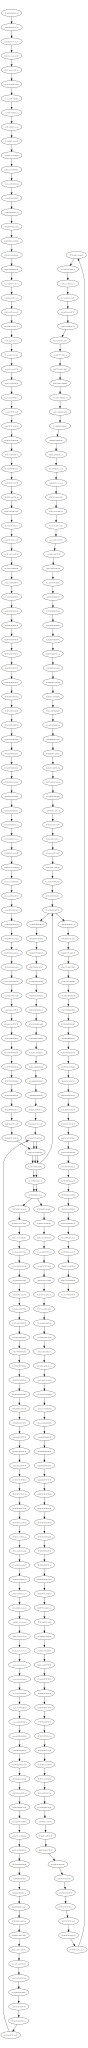

In [33]:
# Helper function to visualize de Bruijn graphs
%dotstr utils.viz_debruijn(nodes_bruijn, edges_bruijn)

In [36]:

nodes_bruijn, edges_bruijn, start = build_graph(sequence_reads)
def assemble_sequence(nodes, edges, start):
    # start with blank sequence and empty stack 
    sequence = ''
    stack = []
    # add the start node to the stack 
    stack.append(start)
    # while the stack is not empty, iterate through the edges 
    # if the first value of the edge (outgoing node) is the node on the top of the stack 
    # (i.e. most recent node added to the stack) 
    # remove the edge from the list of edges 
    # add second value of edge (incoming node) to the stack
    # if top of stack is not one of the outgoing nodes in the edges left 
    # pop the node from the top of the stack and 
    # add the last letter of node on top of stack to the sequence 
    
    while len(stack) != 0:
        end = True
        for e in edges: 
            if stack[-1] == e[0]:
                edges.remove(e)
                stack.append(e[1])
                end = False
                break
        if end: 
            sequence += (stack.pop(-1)[-1])
            
    # reverse the sequence (it was written from finish to start)
    sequence = sequence[::-1]
    
    # add start node up to last letter to the beginning of the sequence
    sequence = start[:-1] + sequence
    return sequence 

In [37]:
# Output assembled sequence

assembled_seq = assemble_sequence(nodes_bruijn, edges_bruijn, start)
print(assembled_seq)
print(len(assembled_seq))

TACGCCAAATAGCAATGCGCAGGATAACAACTTATGTACTACATGTTGTTTCTCGTGCCCGCCAATGTCGAGAGATTTGTGCTATCGCAACCTAAGAGAGAAGGGGTTTTGTGTTAGCAGTTTCTTCATGCATCTCTTTACAAGAATTACAGGAGCCAAACACTCGCTGTCATGGTATCGACATATCGCTGCCCGGAGGCGCTATCGCAAACCGACTGTCGGACTCTTTCATGAGCAAAAAAAGTGGGAGTATGGTGCACATCCGCTATCGCTACTGGTGCCGCCCTTCGATGCAATGTT
300


## Question 2 - Sequencing SARS-CoV-2 virus

Let's move on from TeleTubbies to real-world organisms. Let's start small- with a variant of the SARS-CoV-2 virus. You're given reads from <i>actual</i> genome sequencing runs in the SARS-CoV2.fastq file provided.

Repeat Question 1.3 on this data. You can re-use your implementation and simply run it on the new data. Print out your reconstructed sequence to a file "output.txt". For this part, we will still assume that all the reads are error-free. Set $k=25$.

In [42]:
# Read sequence reads
sequence_reads_covid, qualities_covid = utils.read_fastq('SARS-CoV2.fastq')

In [43]:
# Read reads into graph
nodes_covid, edges_covid = build_graph(sequence_reads_covid)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Call main assembly algorithm
assmebled_covid_seq = assemble_sequence(nodes_covid, edges_covid)

In [ ]:
# Write assembled sequence to file

assmebled_seq = "" # Use your assembled genome
with open("covid_overlap.txt", "w") as f:
    f.write(assmebled_seq)

In [ ]:
print(assembled_covid_seq)
print(len(assembled_covid_seq))

# Question 3- Error-Aware Assembly (Extra Credit)

In the parts above, we assumed error-free reads while assembling $k$-mers. As much as we'd like that, actual reads can (and do) have errors, captured by their Phred scores. For this question, you're given raw, actual reads from sequencing runs (download reads here: https://sra-pub-sars-cov2.s3.amazonaws.com/sra-src/SRR11528307/ABS2-LN-R1_cleaned_paired.fastq.gz).  Given these reads and their Phred33 scores, can you assemble the genome?

<b>Print out your assembled sequence, along with a brief explanation of how your algorithm works</b>

This is an open-ended question. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have, in the cells below.